# Statistik nach Bundesland

Notebook erzeugt `df_join` und wertet anschließend nach Bundesland aus.

In [1]:
import requests
import pandas as pd

## 1) Provider-Facets (dataprovider_id)
Aus der DDB-Suche kommt eine Facet-Statistik zu `dataprovider_id` (Anzahl Objekte pro Provider).
Das Ergebnis steht als DataFrame `df` bereit und ist auf 32-stellige Provider-IDs gefiltert.

In [2]:
url = "https://api.deutsche-digitale-bibliothek.de/2/search/index/search/select"
params = {
    "q": "*:*",
    "rows": 0,
    "facet": "true",
    "facet.field": "dataprovider_id",
    "facet.limit": -1,
    "facet.sort": "count",
    "wt": "json",
}

resp = requests.get(url, params=params, timeout=300)
resp.raise_for_status()
data = resp.json()

facet_list = data["facet_counts"]["facet_fields"]["dataprovider_id"]  # ["id1", count1, "id2", count2, ...]
pairs = list(zip(facet_list[0::2], facet_list[1::2]))

df = pd.DataFrame(pairs, columns=["dataprovider_id", "count"])
df["dataprovider_id"] = df["dataprovider_id"].astype(str)
df["count"] = pd.to_numeric(df["count"], errors="coerce").fillna(0).astype("int64")

df = df[df["dataprovider_id"].str.len() == 32].reset_index(drop=True)

df

,dataprovider_id,count
0,2Q37XY5KXJNJE5MV6SWP3UKKZ6RSBLK5,7668317
1,XYMQPA4OHAYDDFYWHV6Q4RFUIISTLQJV,6551893
2,VSHJWG7QLS7Y3NS2HKE43E5Q5NJ7OCLS,4144240
3,UG6LMRBTZUJVW6YRDFGWG6CS2TMNUOK7,3228053
4,PE423JPDSCU6C72BAC2PUBOHAINDRGFO,2675700
...,...,...
815,PO2SRBK67WA77KXNBM4OTLK3QBQZVLUU,1
816,VH3B3BVEVLGX2XZA5SRAL2CYJOW6YV76,1
817,VJTKMQU5TUCJUM6IAK3AIAKZ42T6TPPT,1
818,X5ZAM2PHVI5EKZZ33QB6XRUBQ6MKA5L7,1


## 2) Organisationsdaten (ddb-institution / ddb-aggregator)
Metadaten zu Einrichtungen/Providern werden aus dem Organisation-Index geladen; Listenfelder werden dabei normalisiert.
Ergebnis: `df_org` (u.a. `label`, `sector_fct`, `city_de_fct`, `state_de_fct`).

In [3]:
# Organization-Daten (ddb-institution) laden -> DataFrame
url_org = "https://api.deutsche-digitale-bibliothek.de/2/search/index/organization/select"
params_org = {
    "q": "type:ddb-institution OR type:ddb-aggregator",
    "fl": "id,label,type,sector_fct,city_de_fct,state_de_fct",
    "rows": 10000,
    "wt": "json",
}

resp_org = requests.get(url_org, params=params_org, timeout=300)
resp_org.raise_for_status()
data_org = resp_org.json()

docs = data_org.get("response", {}).get("docs", [])

def _as_list(value):
    if value is None:
        return []
    # Solr liefert bei *_fct i.d.R. Listen; zur Sicherheit wird auch ein Scalar zu einer Liste normalisiert
    return value if isinstance(value, list) else [value]

df_org = pd.DataFrame({
    "id": [d.get("id") for d in docs],
    "label": [_as_list(d.get("label")) for d in docs],
    "type": [d.get("type") for d in docs],
    "sector_fct":  [d.get("sector_fct") for d in docs],
    "city_de_fct": [_as_list(d.get("city_de_fct")) for d in docs],
    "state_de_fct": [_as_list(d.get("state_de_fct")) for d in docs],
})

df_org

,id,label,type,sector_fct,city_de_fct,state_de_fct
0,5IMBCSZN7ZVL77HVH4GKX3GXNPD6X2NO,[Deutsche Fotothek],ddb-aggregator,sec_05,[Dresden],[Sachsen]
1,DWIVLJW5JBO7X4XRO2Y7PCGZSHLTUS6F,[Digitales Kunst- und Kulturarchiv Düsseldorf ...,ddb-aggregator,sec_07,[Düsseldorf],[Nordrhein-Westfalen]
2,3IJSQ3OFJZCXLJLKDTIQIPYYS5TUMJLB,[Bayerische Julius-Maximilians-Universität Wür...,ddb-institution,sec_04,[Würzburg],[Bayern]
3,CLELTYIEQZZMAYTTNY6TN4BV3KH6OXMT,[Franckesche Stiftungen],ddb-institution,sec_07,[Halle (Saale)],[Sachsen-Anhalt]
4,2ZIDL3W7JH7TC5AX63VFNLA5S3YJTQIY,[Technische Universität Dresden],ddb-institution,sec_04,[Dresden],[Sachsen]
...,...,...,...,...,...,...
4944,4N352HQISWFBP37MFWD3PQSJIVCZ2WTY,[Stadtarchiv Neustadt in Holstein],ddb-institution,sec_01,[Neustadt in Holstein],[Schleswig-Holstein]
4945,QGCRF5ETJ7S746OUN3EWT76HLCI2EJNF,[Stadtarchiv Holzminden],ddb-institution,sec_01,[Holzminden],[Niedersachsen]
4946,5XW2AKKSDPK3RF5NXIFRV4WOYOVF5UFW,[Kreisarchiv des Landkreises Verden],ddb-institution,sec_01,[Verden (Aller)],[Niedersachsen]
4947,6RZWY2PNOT35GHAV3V5A3WOOMMFLMCUA,[Deutsches Adelsarchiv],ddb-institution,sec_01,[Marburg],[Hessen]


## 3) Join & Export (`df_join`)
Die Provider-Facet-Statistik (`df`) wird mit den Organisationsdaten (`df_org`) zusammengeführt.
So stehen pro `dataprovider_id` u.a. `label` und `state_de_fct` zur Verfügung; optionaler Export nach Excel.

In [ ]:
# Join: Provider-Facets (df) + Organisationsdaten (df_org)
df_org["id"] = df_org["id"].astype(str)

df_join = df.merge(df_org, left_on="dataprovider_id", right_on="id", how="outer")

# Für Excel: Array-Spalten lesbar als Strings serialisieren (Listen -> '; '-String)
for col in ["label", "city_de_fct", "state_de_fct"]:
    if col in df_join.columns:
        df_join[col] = df_join[col].apply(lambda xs: "; ".join(map(str, xs)) if isinstance(xs, list) else ("" if xs is None else str(xs)))

# Optional: doppelte Join-Spalte entfernen und Spaltenordnung setzen
if "dataprovider_id" in df_join.columns:
    df_join = df_join.drop(columns=["dataprovider_id"])

df_join = df_join[["id", "label", "type", "sector_fct", "city_de_fct", "state_de_fct", "count"]]

# Ergebnis in Excel-Datei speichern mit Datum
out_path = "statistic-federal_state_" + pd.Timestamp.now().strftime("%Y-%m-%d") + ".xlsx"
df_join.to_excel(out_path, index=False)

df_join

,id,label,type,sector_fct,city_de_fct,state_de_fct,count
0,2232YVSIZTZYDAZIBI25LW3TZUY6DZVH,Bayerisches Hauptstaatsarchiv,ddb-institution,sec_01,München,Bayern,547576.0
1,226MOGFFOBKT6CHOUZTN7YNJSQBBDW44,TU Dresden - Institut für Zoologie,ddb-institution,sec_04,Dresden,Sachsen,NaN
2,22TRYIUQYEFVQ3VION3IC3COCUCXDE6Q,"Archiv des Freiherrn von Loe, Raphael",ddb-institution,sec_01,Weeze,Nordrhein-Westfalen,NaN
3,23H2TZEXAWO4MNHRYEGGR7FWP4KZQLZ2,SLUB Dresden. Zweigbibliothek Forstwesen,ddb-institution,sec_02,Tharandt,Sachsen,NaN
4,23SQB2WOH356NR7UHLNPB6UQOWNFAU5J,Kreisarchiv des Kreises Steinburg und der Stad...,ddb-institution,sec_01,Itzehoe,Schleswig-Holstein,NaN
...,...,...,...,...,...,...,...
4944,ZZ73OW3EYCPB6AW4NX7JSWIBCD6KCFOG,Stadtarchiv Crailsheim,ddb-institution,sec_01,Crailsheim,Baden-Württemberg,NaN
4945,ZZCJXBDSTGE54QDZOKZRFUN2MWY5O6NX,Kreisarchiv des Saale-Holzland-Kreises,ddb-institution,sec_01,Eisenberg,Thüringen,NaN
4946,ZZDXSR6MZGWV7LMPQ5PDJNFXVTKDDIMK,Stadtarchiv Gevelsberg,ddb-institution,sec_01,Gevelsberg,Nordrhein-Westfalen,NaN
4947,ZZT2BWVIDOAU2KRL6MQJZOYVOSLFYFJ4,Stadtarchiv Göppingen,ddb-institution,sec_01,Göppingen,Baden-Württemberg,NaN


## 4) Auswertung nach Bundesland (`agg`)
Aus `df_join` wird pro Bundesland aggregiert:
- Anzahl Einrichtungen (gesamt)
- Anzahl *liefernder* Einrichtungen (`count > 0`)
- Summe der Objekte (`count`)
Ergebnis: DataFrame `agg` (absteigend sortiert).

In [5]:
# Bundesland-Auswertung (pandas-only)

# Hinweis: Diese Zelle setzt voraus, dass oben bereits df_join erzeugt wurde.

df_bl = df_join.loc[df_join["id"].notna(), ["id", "state_de_fct", "count"]].copy()
df_bl["count"] = pd.to_numeric(df_bl["count"], errors="coerce").fillna(0).astype("int64")

# state_de_fct ist nach dem Join serialisiert ("; "-getrennt). Für die Zuordnung wird der erste Wert verwendet.
df_bl["bundesland"] = (
    df_bl["state_de_fct"]
    .fillna("")
    .astype(str)
    .str.split("; ")
    .str[0]
    .str.strip()
    .replace({"": "Ausland"})
)

einrichtungen = df_bl.groupby("bundesland")["id"].nunique().rename("einrichtungen")
liefernde = (
    df_bl.loc[df_bl["count"] > 0]
    .groupby("bundesland")["id"]
    .nunique()
    .rename("liefernde_einrichtungen")
)
objekte = df_bl.groupby("bundesland")["count"].sum().rename("objekte")

agg = (
    pd.concat([einrichtungen, liefernde, objekte], axis=1)
    .fillna(0)
    .astype({"einrichtungen": "int64", "liefernde_einrichtungen": "int64", "objekte": "int64"})
    .sort_values(["objekte", "liefernde_einrichtungen", "einrichtungen"], ascending=False)
)

agg

,einrichtungen,liefernde_einrichtungen,objekte
bundesland,,,
Baden-Württemberg,589,57,11004229
Hessen,382,57,9878446
Nordrhein-Westfalen,883,157,9332725
Sachsen,385,54,7070368
Bayern,600,58,6390424
Berlin,304,108,5206849
Rheinland-Pfalz,165,29,4553607
Sachsen-Anhalt,144,21,1972997
Schleswig-Holstein,337,43,1774401


## 5) Visualisierung
Zwei horizontale Balkendiagramme (Top-N):
- Objekte je Bundesland
- Einrichtungen vs. datenliefernde Einrichtungen je Bundesland

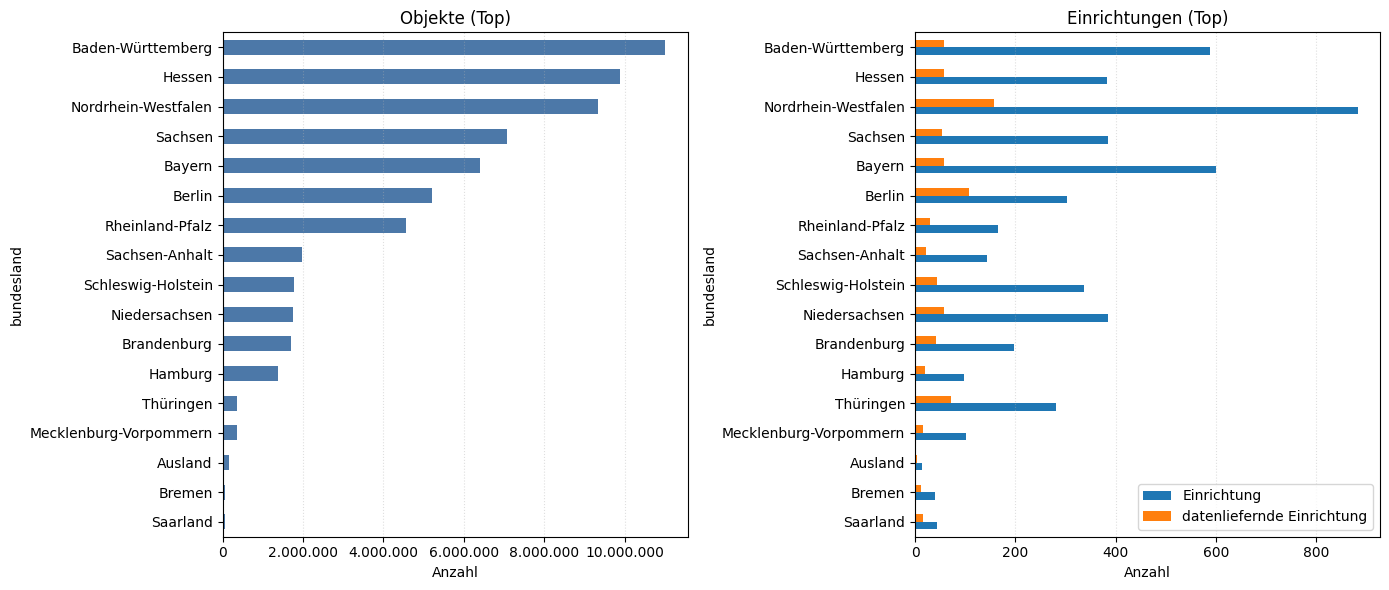

In [6]:
# Visualisierung (pandas plot; benötigt matplotlib)
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

top_n = 20
plot_df = agg.head(top_n).copy()
plot_df = plot_df.iloc[::-1]  # für barh: klein -> groß

fig, axes = plt.subplots(1, 2, figsize=(14, max(6, 0.35 * len(plot_df))))

def _format_int_no_sci(x, pos):
    _ = pos  # required by FuncFormatter signature
    return f"{x:,.0f}".replace(",", ".")

# Objekte
plot_df["objekte"].plot(kind="barh", ax=axes[0], color="#4C78A8")
axes[0].set_title("Objekte (Top)")
axes[0].set_xlabel("Anzahl")
axes[0].grid(axis="x", linestyle=":", alpha=0.4)
axes[0].xaxis.set_major_formatter(FuncFormatter(_format_int_no_sci))

# Einrichtungen vs. liefernde Einrichtungen
plot_df_inst = plot_df.rename(columns={
    "einrichtungen": "Einrichtung",
    "liefernde_einrichtungen": "datenliefernde Einrichtung",
})
plot_df_inst[["Einrichtung", "datenliefernde Einrichtung"]].plot(kind="barh", ax=axes[1])
axes[1].set_title("Einrichtungen (Top)")
axes[1].set_xlabel("Anzahl")
axes[1].grid(axis="x", linestyle=":", alpha=0.4)
axes[1].legend(loc="lower right")

fig.tight_layout()
plt.show()